# Assignment 2
## Question 1: OpenCL CSR matrix-vector product

**Given a sparse matrix in CSR format. Develop a class that derives from Scipy LinearOperator and which is initialised with data, indices, and indptr array that describe the sparse matrix. The class shall provide an efficient OpenCL accelerated matrix-vector product.**

In [33]:
%matplotlib inline
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt

**Ordinary sparse matrix multiplication:**

In LinearOperator, you only need to implement sparse matrix multiplication by vector to automatically implement sparse matrix multiplication by matrix.

The sparse matrix is multiplied by the v vector to obtain a vector res. The i-th element in the vector res is equal to the dot product of the i-th row and the v-vector of the sparse matrix.

**The process of finding the dot product:**

Multiply only the non-zero elements of the sparse matrix with the elements of the corresponding v-vector.

In [34]:
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import LinearOperator, cg

### In this cell, we create a class that inherits LinearOperator and implement matrix multiplication of sparse matrices, but does not use OpenCL to accelerate.

        
* Find the i-th element of the result vector.
* From indptr[i] to indptr[i+1] is the index range of all non-zero elements in the i-th row of the sparse matrix in the data vector.
* The indices[indptr[i]] and the indices[indptr[i+1]] are the column indices corresponding to the non-zero elements of the i-th row, and are also the indices of the corresponding elements in the x-multiplication vector.
* Implement matrix multiplication (np.dot): Find the dot product.

In [35]:
class SparseMatrixLinearOperator(LinearOperator):
    def __init__(self, data, indices, indptr):
        self.data = data
        self.indices = indices
        self.indptr = indptr
        self.csr = csr_matrix((data, indices, indptr))
        self.shape = self.csr.shape

    def _matvec(self, x):
        assert x.shape[0] == self.shape[1], "dimension must match"
        y = np.zeros(x.shape[0], dtype=np.float32)

        for i in range(self.shape[1]):
            y[i] = np.dot(self.data[self.indptr[i]: self.indptr[i + 1]],
                          x[self.indices[self.indptr[i]]: self.indptr[i + 1]])

        return y

### SparseMatrixLinearOperator Test 1

In [36]:
n = 100000
csr = eye((n), dtype=np.float32).tocsr()
smlo = SparseMatrixLinearOperator(csr.data, csr.indices, csr.indptr)
x = np.random.rand(n)

### Run time test: 

Use the magic functions %%time and %%timeit in the notebook to test the running time of the code in the cell, where time test 1 time; timeit test multiple times, and then take the average.

Smlo(x) means smlo * x, which is smlo.matvec(x) and calls the _matvec_ method written above.

In [37]:
%%timeit

smlo(x)

664 ms ± 40.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
smlo * x

array([0.5140028 , 0.6770125 , 0.36885238, ..., 0.04011555, 0.7034923 ,
       0.7518228 ], dtype=float32)

### In this cell, we create a class that uses OpenCL to accelerate.

**Write core functions:**
* Find the gid-th number in the result vector.
* 'start' and 'end' are the positions of the non-zero elements of the gid-th line in the CSR matrix of data.
* indices[i] is the column index corresponding to the element, and is also the corresponding index in the vector v.

In [39]:
class SparseMatrixLinearOperatorOpenCL(LinearOperator):
    def __init__(self, data, indices, indptr):
        self.data = data
        self.indices = indices
        self.indptr = indptr
        self.csr = csr_matrix((data, indices, indptr))
        self.shape = self.csr.shape

    def _matvec(self, x):
        assert x.shape[0] == self.shape[1], "dimension must match"
        
        # ctx = cl.create_some_context()
        ctx = cl.Context(dev_type = cl.device_type.GPU)
        queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
        mf = cl.mem_flags
        
        # Input data and convert to buffer in OpenCL  
        data_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=self.data.astype(np.float32)) # float32
        indices_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=self.indices)
        indptr_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=self.indptr)
        
        # Core functions  
        self.prg = cl.Program(ctx, """
        __kernel void matvec(__global const float *data, __global const int *indices, \
            __global const int *indptr, __global const float *x, __global float *y)
        {
            int gid = get_global_id(0);
            int start = indptr[gid], end = indptr[gid + 1];
            float tmp = 0.0;
            for (int i = start; i < end; ++i) {
                tmp += data[i] * x[indices[i]];
            }
            y[gid] = tmp;
        }
        """).build()

        # Create Buffer  
        x_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x.astype(np.float32))
        res = np.zeros_like(x, dtype=np.float32)
        res_g = cl.Buffer(ctx, mf.WRITE_ONLY | mf.COPY_HOST_PTR, hostbuf=res)

        # Run the OpenCL program  
        self.prg.matvec(queue, x.shape, None, data_g, indices_g, indptr_g, x_g, res_g)
        
        # Copy the result to res  
        cl.enqueue_copy(queue, res, res_g)
        
        return res

### SparseMatrixLinearOperatorOpenCL Test 2

In [40]:
n = 100000
csr = eye((n), dtype=np.float32).tocsr()
smloo = SparseMatrixLinearOperator(csr.data, csr.indices, csr.indptr)
x = np.random.rand(n)

### Run time test: The method using OpenCL is slightly faster

In [41]:
%%timeit

smloo(x)

665 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
smloo * x

array([7.4626768e-01, 7.2083455e-03, 5.7834829e-04, ..., 6.1834371e-01,
       5.4235137e-01, 2.7389529e-01], dtype=float32)

## Question 2: Potentials generated by random particles

**We consider the Laplace equation on the unit square with zero conditions on the boundary. Develop a LinearOperator that takes a vector u of values on an M * M grid (xi,yj) for xi = i/M+1, j = 1,...,M and yi described in the same way, and returns the approximate evaluation of f for this vector.**

### In this cell, we create a class that inherits LinearOperator and implement matrix multiplication of sparse matrices, and use OpenCL to accelerate.

**Five-point stencil:**
* In numerical analysis, given a square grid in one or two dimensions, the five-point stencil of a point in the grid is a stencil made up of the point itself together with its four "neighbors". Then we can use it to write finite difference approximations to derivatives at grid points.
* Here, we use this stencil to approximate the Laplacian of a function of two variables, with the error in this approximation is O(h^2)

**Write core functions:**
* For each interior point, we have fi,j = (4ui,j-ui+1,j-ui-1,j-ui,j-1-ui,j+1)/h^2
* But sometimes, when we calculate the 5 points stencil, there are some points lie outside the boundary of the grid we defined. So when we create the kernel in OpenCL, we need to determine whether there are points outside the grid. And if they are, we need to set these points to zero, which subject to boundary conditions.

In [43]:
# Define the class of StencilOperatorOpenCL, which implements the five point stencil
class StencilOperatorOpenCL(LinearOperator):
    
    def __init__(self, m):
        self.m = m
        self.shape = (m * m, m * m)
    
    def _matvec(self, u):
        
        #Create a GPU specific context and command queue
        # ctx = cl.create_some_context()
        # ctx = cl.Context(dev_type = cl.device_type.GPU)
        ctx = cl.Context(dev_type=cl.device_type.ALL, \
                         properties=[(cl.context_properties.PLATFORM, cl.get_platforms()[0])])
        queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
        mf = cl.mem_flags
        
        # Core functions 
        self.prg = cl.Program(ctx, """
         __kernel void stencil(const int m, const float h, __global const float *u, __global float *v)
        {
            int i = get_global_id(0);
            int j = get_global_id(1);
        
            v[i * m + j] = 4 * u[i * m + j] - ((i - 1) < 0 ? 0 : u[(i - 1) * m + j]) - \
                ((i + 1) > (m - 1) ? 0 : u[(i + 1) * m + j]) - ((j - 1) < 0 ? 0 : u[i * m + (j - 1)]) - \
                ((j + 1) > (m - 1) ? 0 : u[i * m + (j + 1)]);
                
            v[i * m + j] /= (h * h);
       }
        """).build()
        
        # Create Buffer
        self.dtype = u.dtype
        u_g = cl.Buffer(ctx, mf.READ_ONLY, size = self.shape[0] * np.dtype(np.float32).itemsize)
        v = np.zeros((self.shape[0]), dtype=np.float32)
        v_g = cl.Buffer(ctx, mf.WRITE_ONLY, size = self.shape[0] * np.dtype(np.float32).itemsize)
        
        cl.enqueue_copy(queue, u_g, u)
        
        # Run the OpenCL program
        self.prg.stencil(queue, (self.m, self.m), (1, 1), np.int32(self.m), \
                         np.float32(1.0 / (self.m - 1)), u_g, v_g)
        
        # Copy the result to v
        cl.enqueue_copy(queue, v, v_g)
        
        return v

### For different values of M plot the convergence curve of the residual r

**Here, we use CG iterative solver in Scipy to acquire the residual r in each iteration for different values of M. At the same time, the right-hand side function is set as f = 1**

In [44]:
# Define the function of callback to save residuals, change the value of M.
M_list = [50, 150, 250, 350, 450]

def callback(xj):
    data.append(np.linalg.norm(b - A * xj) / np.linalg.norm(b))

data_all = []
data = []

for M in M_list:
    A = StencilOperatorOpenCL(M)
    data.clear()
    u = np.full((M, M), 5, np.float32)    
    x0 = u.flatten()
    b = np.ones((M * M), np.float32)
    res = cg(StencilOperatorOpenCL(M), b, x0, 1e-5, 460, callback = callback)
    print(res)
    data_all.append(data.copy())

(array([0.00096723, 0.00172572, 0.00235818, ..., 0.00235805, 0.00172574,
       0.00096724], dtype=float32), 460)
(array([0.0001364 , 0.00024926, 0.00034843, ..., 0.00034863, 0.00024922,
       0.00013639], dtype=float32), 460)
(array([5.3978907e-05, 9.9717523e-05, 1.4048198e-04, ..., 1.4072712e-04,
       9.9764788e-05, 5.3917211e-05], dtype=float32), 460)
(array([4.07818625e-05, 7.64785436e-05, 1.10316716e-04, ...,
       1.11223235e-04, 7.83712167e-05, 4.18878626e-05], dtype=float32), 460)
(array([3.8746522e-05, 6.5550477e-05, 9.8136821e-05, ..., 9.7972756e-05,
       6.6070512e-05, 4.0164057e-05], dtype=float32), 460)


From the picture below, we find that the smaller the value of M is, the faster the convergence is.

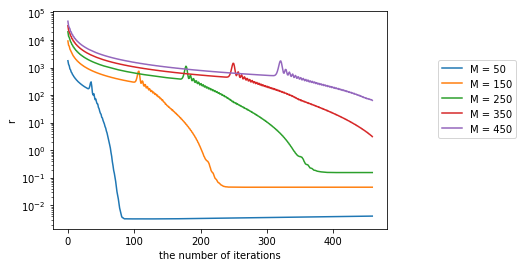

In [45]:
# Use a semilogy plot
for i, M in enumerate(M_list):
    plt.semilogy(np.arange(460), data_all[i], label='M = {}'.format(M))

plt.xlabel('the number of iterations')
plt.ylabel('r')
plt.legend(bbox_to_anchor = (1.4, 0.8))

plt.show()

### Investigate how the number of iterations grows as M increases

[120, 265, 411, 460, 460]


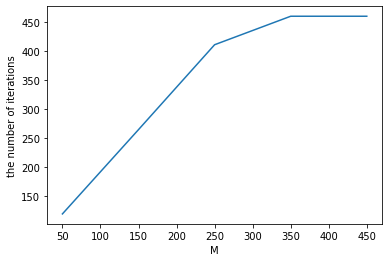

In [54]:
# Define a function used to find best iteration of each M
def best_iteration(data):
    data = np.array(data)
    diff = abs((data[1:] - data[:-1]) / data[:-1])
    for i, ele in enumerate(diff):
        if ele < 1e-5:
            return i + 1
    return len(data)

iterations = []

for data in data_all[:5]:
    iterations.append(best_iteration(data))
print(iterations)
# Plot
plt.plot(M_list, iterations)
plt.xlabel("M")
plt.ylabel("the number of iterations")

plt.show()

### Produce nice plots of the solution u on the unit square

In [55]:
def plot(m, n, data):
    M = range(m)
    N = range(n)
    M, N = np.meshgrid(M, N)
    z = data[M, N]
    all_image.append(z)

M = 50

u = np.full((M, M), 5, dtype=np.float32)
b = np.ones((M * M), dtype=np.float32)

# Control the output and store required nice plots
cnt = 0
all_image = []

def solution(xj):
    global cnt
    cnt += 1
    if cnt % 10 == 0:    
        data = xj.reshape(M, M)
        plot(M, M, data)
    
solution = cg(StencilOperatorOpenCL(M), b, x0 = u.flatten(), maxiter = 120, callback = solution)
print(solution)

(array([0.00096676, 0.00172561, 0.00235811, ..., 0.00235802, 0.00172542,
       0.00096686], dtype=float32), 120)


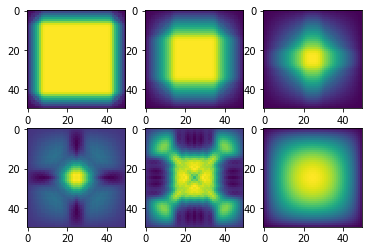

In [57]:
# plot the solution
fig = plt.figure()
plt.subplot(231)
plt.imshow(all_image[0])
plt.subplot(232)
plt.imshow(all_image[1])
plt.subplot(233)
plt.imshow(all_image[2])
plt.subplot(234)
plt.imshow(all_image[3])
plt.subplot(235)
plt.imshow(all_image[4])
plt.subplot(236)
plt.imshow(all_image[11])
plt.show()

In [51]:
len(all_image)

15